In [43]:
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

In [44]:
model = BertForQuestionAnswering.from_pretrained('google-bert/bert-large-uncased-whole-word-masking-finetuned-squad')

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-large-uncased-whole-word-masking-finetuned-squad')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [56]:
question = "Who published something in 1687?"
answer_text = "Newton's laws of motion are three laws that describe the relationship between the motion of an object and the forces acting on it. The three laws of motion were first stated by Isaac Newton in his Philosophiæ Naturalis Principia Mathematica (Mathematical Principles of Natural Philosophy), originally published in 1687."

In [57]:
input_ids = tokenizer.encode(question, answer_text)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
for token, id in zip(tokens, input_ids):
    if id == tokenizer.sep_token_id:
        print('')
    print('{:<12} {:>6}'.format(token, id))
    if id == tokenizer.sep_token_id:
        print('')

[CLS]           101
who            2040
published      2405
something      2242
in             1999
168           16923
##7            2581
?              1029

[SEP]           102

newton         8446
'              1005
s              1055
laws           4277
of             1997
motion         4367
are            2024
three          2093
laws           4277
that           2008
describe       6235
the            1996
relationship   3276
between        2090
the            1996
motion         4367
of             1997
an             2019
object         4874
and            1998
the            1996
forces         2749
acting         3772
on             2006
it             2009
.              1012
the            1996
three          2093
laws           4277
of             1997
motion         4367
were           2020
first          2034
stated         3090
by             2011
isaac          7527
newton         8446
in             1999
his            2010
phil           6316
##oso         1913

In [58]:
sep_index = input_ids.index(tokenizer.sep_token_id)
num_seg_a = sep_index + 1
num_seg_b = len(input_ids) - num_seg_a
segment_ids = [0] * num_seg_a + [1] * num_seg_b
assert len(segment_ids) == len(input_ids)

In [59]:
outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True) 
start_scores = outputs.start_logits
end_scores = outputs.end_logits

In [60]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "isaac newton"


In [61]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "isaac newton"


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [63]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

C:\Users\USER\AppData\Local\Temp\ipykernel_22536\2520861439.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
C:\Users\USER\AppData\Local\Temp\ipykernel_22536\2520861439.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


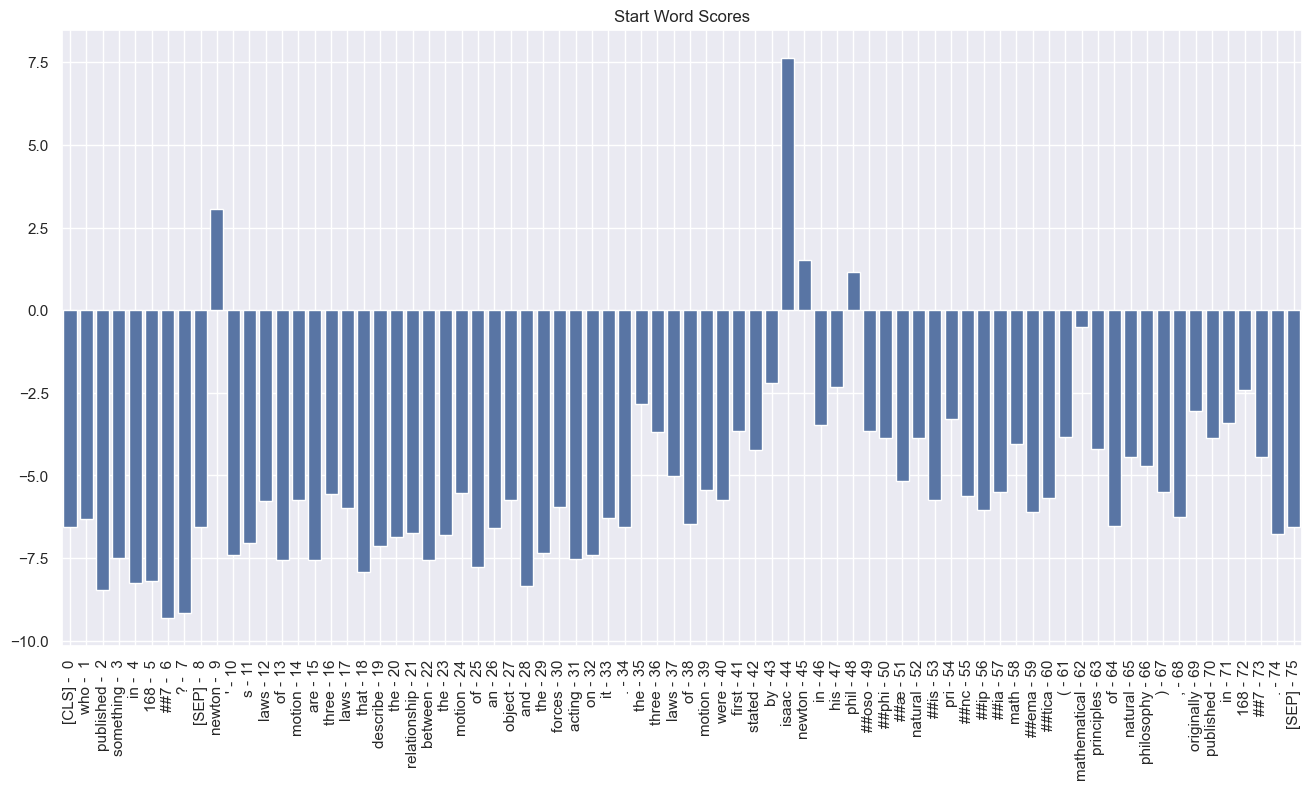

In [64]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_22536\645875075.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
C:\Users\USER\AppData\Local\Temp\ipykernel_22536\645875075.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


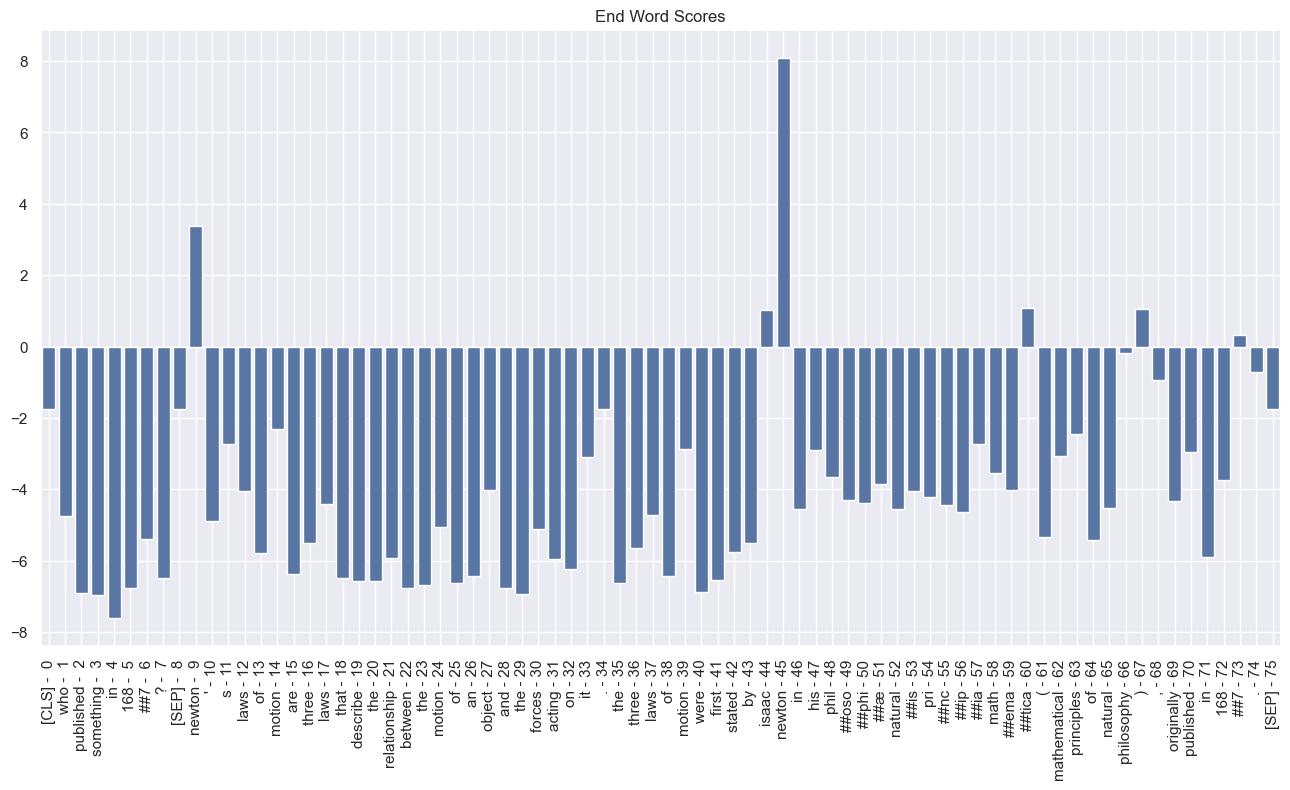

In [65]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()